# Assignment 3

### <span style="color:chocolate"> Submission requirements </span>

Your work will not be graded if your notebook doesn't include output. In other words, <span style="color:red"> make sure to rerun your notebook before submitting to Gradescope </span> (Note: if you are using Google Colab: go to Edit > Notebook Settings  and uncheck Omit code cell output when saving this notebook, otherwise the output is not printed).

Additional points may be deducted if these requirements are not met:

    
* Comment your code;
* Each graph should have a title, labels for each axis, and (if needed) a legend. Each graph should be understandable on its own;
* Try and minimize the use of the global namespace (meaning, keep things inside functions).
---

### Import libraries

In [ ]:
!pip install keras_tuner

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 2.7 MB/s eta 0:00:00


In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns  # for nicer plots
sns.set(style="darkgrid")  # default style
from sklearn.model_selection import train_test_split
import tensorflow as tf
from matplotlib import pyplot as plt
import keras_tuner as kt
from keras_tuner import HyperParameters

This lab continues our study of linear regression. You'll train your first models with Tensorflow, using a real dataset to predict car prices from their features. Note that Tensorflow is a rapidly changing library. This means you'll often see warnings about deprecations. You can ignore the warnings in our labs.

---
### Step 1: Data ingestion

You'll use the [Automobile Data Set](https://archive.ics.uci.edu/ml/datasets/automobile)  from 1985 Ward's Automotive Yearbook that is part of the [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets).

This dataset has been pre-downloaded and uploaded to bCourses alongside this notebook for your convenience.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os

w207_assignments_path = '/content/drive/My Drive/Colab Notebooks/w207/w207 Assignments'

os.chdir(w207_assignments_path)

In [ ]:
car_data_init = pd.read_csv("./automobile_data.txt")

# Display top five rows
print('Shape of data:', car_data_init.shape)
car_data_init.head()

Shape of data: (205, 26)


,normalized-losses,make,fuel-type,aspiration,num-of-doors,body-style,drive-wheels,engine-location,wheel-base,length,...,fuel-system,bore,stroke,compression-ratio,horsepower,peak-rpm,city-mpg,highway-mpg,price,symboling
0,NaN,alfa-romero,gas,std,2.0,convertible,rwd,front,88.6,168.8,...,mpfi,3.47,2.68,9.0,111.0,5000.0,21,27,13495.0,3
1,NaN,alfa-romero,gas,std,2.0,convertible,rwd,front,88.6,168.8,...,mpfi,3.47,2.68,9.0,111.0,5000.0,21,27,16500.0,3
2,NaN,alfa-romero,gas,std,2.0,hatchback,rwd,front,94.5,171.2,...,mpfi,2.68,3.47,9.0,154.0,5000.0,19,26,16500.0,1
3,164.0,audi,gas,std,4.0,sedan,fwd,front,99.8,176.6,...,mpfi,3.19,3.40,10.0,102.0,5500.0,24,30,13950.0,2
4,164.0,audi,gas,std,4.0,sedan,4wd,front,99.4,176.6,...,mpfi,3.19,3.40,8.0,115.0,5500.0,18,22,17450.0,2


---
### Step 2: Data preprocessing

This step is essential for preparing the data in a format that is suitable for ML algorithms. It helps ensure data quality and improvements in model performance.

### <span style="color:chocolate">Exercise 1:</span> Column selection (5 points)

To keep things simple, you will:

1. Retain only the following columns: ['horsepower', 'peak-rpm', 'city-mpg', 'highway-mpg', 'price']. Name the new dataframe *car_data*.
2. Display the data type of each column;
3. Convert the data type of each columns to numeric. Coerce missing values to NaN. Hint: use <span style="color:chocolate">pd.to_numeric()</span> method;
4. Display the data type of each column after the transformation performed at point 3.


In [ ]:
# YOUR CODE HERE

# Retaining only the specified columns
car_data = car_data_init[
    ['horsepower', 'peak-rpm', 'city-mpg', 'highway-mpg', 'price']]

print('Displaying the data type of each column:')
print(car_data.dtypes, '\n')

# Converting the data type of each column to numeric and coercing missing
# values to NaN
car_data = car_data.apply(pd.to_numeric, errors = 'coerce')

print('Displaying the data type of each column after converting to numeric:')
print(car_data.dtypes)


Displaying the data type of each column:
horsepower     float64
peak-rpm       float64
city-mpg         int64
highway-mpg      int64
price          float64
dtype: object 

Displaying the data type of each column after converting to numeric:
horsepower     float64
peak-rpm       float64
city-mpg         int64
highway-mpg      int64
price          float64
dtype: object


### <span style="color:chocolate">Exercise 2:</span> Example (row) selection (5 points)

To keep things simple again, you will:

1. Print the shape of the car_data;

2. Remove examples (rows) that have missing value(s). Note that in doing so, you will overwrite the car_data dataset. You should end up with 199 examples after this cleaning.

3. Print the shape of the car_data again.

It's important to acknowledge that there are multiple approaches to handling missing features, and simply discarding examples with any missing feature, though straightforward, may not be the most optimal solution. However, for the sake of simplicity, you will implement this strategy in this assignment.

In [ ]:
# YOUR CODE HERE

print('Printing the shape of car_data:', car_data.shape, '\n')

# Removing rows that have missing values
car_data = car_data.dropna(ignore_index = True)

print('Printing the shape of car_data after dropping NaN:', car_data.shape)

Printing the shape of car_data: (205, 5) 

Printing the shape of car_data after dropping NaN: (199, 5)


### <span style="color:chocolate">Exercise 3:</span> Data shuffling (10 points)

Since you'll be using Batch Gradient Descent (BGD) for training, it is important that **each batch is a random sample of the data** so that the gradient computed is representative. Note that the original data (above) appears sorted by *make* in alphabetic order.

Using NumPy and Pandas methods:

1. Create a list of indices corresponding to the rows in the car_data dataset. Call this list *indices*. Print this list;

2. Shuffle *indices* using the <span style="color:chocolate">np.random.permutation()</span> method. Call the resulting array *shuffled_indices*. Print this array;
    
3. Use the method <span style="color:chocolate">dataframe.reindex()</span> to change the ordering of the car_data dataset based on the order in the *shuffled_indices* array. Note that in doing so, you will overwrite the original dataset. Print the top 5 rows.

In [ ]:
np.random.seed(0)
# YOUR CODE HERE

# Creating a list of indices corresponding to the rows in car_data dataset
indices = np.arange(car_data.shape[0])
print('Printing list of indices:')
print(indices, '\n')

# Creating shuffed_indices array
shuffled_indices = np.random.permutation(indices)
print('Printing list of shuffled indices:')
print(shuffled_indices, '\n')

# Reordering the car_data dataset based on the order in shuffled_indices
car_data = car_data.reindex(shuffled_indices)
print('Printing the top 5 rows of reordered car_data dataset:')
car_data.head()

Printing list of indices:
[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198] 

Printing list of shuffled indices:
[ 18 169 106  92 176 183   5 139  12 160  61 124 164 145  80   7  33 129
  37  74 159 144  45 158  60 122 178 184  97  44  16  5

,horsepower,peak-rpm,city-mpg,highway-mpg,price
18,70.0,5400.0,38,43,6295.0
169,92.0,4200.0,27,32,9988.0
106,97.0,5000.0,19,24,12440.0
92,69.0,5200.0,31,37,7799.0
176,52.0,4800.0,37,46,7775.0


### <span style="color:chocolate">Exercise 4:</span> Define outcome and features (5 points)

Create two dataframes as follows:

1. The first dataframe contains our outcome of interest: ['price']. Note, this is what we are aiming to predict. Name this dataframe Y. Print shape of Y.
2. The second dataframe contains our features of interest: ['horsepower', 'peak-rpm', 'city-mpg', 'highway-mpg']. Name this dataframe X. Print shape of X.


In [ ]:
# YOUR CODE HERE

# Creating our dataframe with our outcome of interest: price
Y = car_data[['price']]
print('Printing the shape of Y:', Y.shape, '\n')

X = car_data[['horsepower', 'peak-rpm', 'city-mpg', 'highway-mpg']]
print('Printing the shape of X:', X.shape)

Printing the shape of Y: (199, 1) 

Printing the shape of X: (199, 4)


### <span style="color:chocolate">Exercise 5:</span> Data splits (10 points)

Using the <span style="color:chocolate">train_test_split()</span> method available in scikit-learn:
1. Partition the (X, Y) data into training, validation, and test sets using a splitting rule of [60%, 20%, 20%], with a random state set to 1234. Name the resulting dataframes as follows: X_train, X_val, X_test, Y_train, Y_val, Y_test. Hint: To create these three partitions you will utilize the train_test_split() method twice (all the other arguments of the method are set to default values.). You should obtain [119, 40, 40] examples for training, validation, and test, respectively.
2. Print the shape of each dataframe.

Note: The validation set is crucial for evaluating different hyperparameter configurations and selecting those that yield optimal model performance. This approach avoids utilizing the test dataset during model training, as it is assumed to be "unknown" at that stage.

In [ ]:
# YOUR CODE HERE

# Setting random state set to 1234 for np and tf
tf.random.set_seed(1234)
np.random.seed(1234)

# Creating splits for the training (temporary) and test data
X_train, X_test, Y_train, Y_test = train_test_split(
    X, Y, test_size = 0.2, random_state = 1234)

# Creating splits for training (final) and validation data
X_train, X_val, Y_train, Y_val = train_test_split(
    X_train, Y_train, test_size = 0.25, random_state = 1234)

print('Printing the shape of X_train:', X_train.shape)
print('Printing the shape of X_val:', X_val.shape)
print('Printing the shape of X_test:', X_test.shape)
print('Printing the shape of Y_train:', Y_train.shape)
print('Printing the shape of Y_val:', Y_val.shape)
print('Printing the shape of Y_test:', Y_test.shape)

Printing the shape of X_train: (119, 4)
Printing the shape of X_val: (40, 4)
Printing the shape of X_test: (40, 4)
Printing the shape of Y_train: (119, 1)
Printing the shape of Y_val: (40, 1)
Printing the shape of Y_test: (40, 1)


### <span style="color:chocolate">Exercise 6:</span> Data standardization (10 points)

With this concept in mind, complete the following tasks:

1. Output the quantile values (0.25, 0.5, 0.75, 0.95) for all features in the X_train dataset. Are these values uniformly scaled across features?

2. Standardize all features in X_train, X_val, and X_test. Label the resulting dataframes as X_train_std, X_val_std, and X_test_std, respectively. Hint: standardize the validation and test data using the mean and standard deviation computed from the training data. Why?

3. Similar to point 2. but now standardize the outcome variable. Label the resulting dataframes as Y_train_std, Y_val_std, and Y_test_std.

In [ ]:
# YOUR CODE HERE

# Outputting the quantile values for all features in X_train
print(X_train.quantile([0.25, 0.5, 0.75, 0.95]), '\n')
print("It's hard to tell whether the data within each feature is scaled")
print("uniformly. However, the values across features are definitely not")
print("uniformly scaled. While city-mpg and highway-mpg may be comparable,")
print("horsepower is undeniably larger; moreover, the peak-rpm feature seems")
print("to be roughly 2 orders of magnitude larger than the other features.")

      horsepower  peak-rpm  city-mpg  highway-mpg
0.25        69.0    4800.0      21.0         25.0
0.50        90.0    5100.0      25.0         30.0
0.75       116.0    5400.0      31.0         37.0
0.95       176.6    5810.0      37.0         42.1 

It's hard to tell whether the data within each feature is scaled
uniformly. However, the values across features are definitely not
uniformly scaled. While city-mpg and highway-mpg may be comparable,
horsepower is undeniably larger; moreover, the peak-rpm feature seems
to be roughly 2 orders of magnitude larger than the other features.


In [ ]:
# Standardizing all features in X_train, X_val, and X_test based on X_train
X_train_mean = X_train.mean()
X_train_stddev = X_train.std()

X_train_std = (X_train - X_train_mean) / X_train_stddev
X_val_std = (X_val - X_train_mean) / X_train_stddev
X_test_std = (X_test - X_train_mean) / X_train_stddev

print("One of the biggest reasons for standardizing data in general is because")
print("we want the learning rate to have an even impact across all features.")
print("However, this should not affect the comparison of how well our model")
print("does against the val and test data with how well it does against the")
print("training data (e.g., a model that may have overfit based on what it")
print("learned in the training data may not perform as well against the")
print("validation or test data). Therefore, we standardize all the data only")
print("against the training data because we want to see how well our model")
print("generalizes to unseen data. If we instead standardize the validation")
print("and test data to their own respective means and stddevs, it would be as")
print("if you already gave your model an edge (since it was trained on data")
print("with mean 0 and stddev 1), inadvertently introducing bias to the model.")

One of the biggest reasons for standardizing data in general is because
we want the learning rate to have an even impact across all features.
However, this should not affect the comparison of how well our model
does against the val and test data with how well it does against the
training data (e.g., a model that may have overfit based on what it
learned in the training data may not perform as well against the
validation or test data). Therefore, we standardize all the data only
against the training data because we want to see how well our model
generalizes to unseen data. If we instead standardize the validation
and test data to their own respective means and stddevs, it would be as
if you already gave your model an edge (since it was trained on data
with mean 0 and stddev 1), inadvertently introducing bias to the model.


In [ ]:
# Standardizing the outcomes in Y_train, Y_val, and Y_test based on Y_train
Y_train_mean = Y_train.mean()
Y_train_stddev = Y_train.std()

Y_train_std = (Y_train - Y_train_mean) / Y_train_stddev
Y_val_std = (Y_val - Y_train_mean) / Y_train_stddev
Y_test_std = (Y_test - Y_train_mean) / Y_train_stddev

---
### Step 3: Exploratory data analysis (EDA)

EDA plays a very important role in ML. The goal here is to develop a good understanding of our training dataset, identify any data quality issues, understand patterns and relationships, which in turn, aids in subsequent modeling and interpretations.

### <span style="color:chocolate">Exercise 7:</span> Scatterplot matrix (10 points)

In this exercise you will use some simple yet useful techniques to visualize the distribution of the data.

Let's start with:

1. A scatterplot matrix to visualize the pair-wise correlations between different features and outcome in the (X_train_std, Y_train_std) data. You will use the <span style="color:chocolate">sns.pairplot()</span> method from the seaborn library imported at the top of the notebook;
2. Is any of the variables in the data normally distributed? Is it necessary for the explanatory or target variable to be normally distributed in order to train a ML model?

Text(0.5, 0.98, 'Scatterplot Matrix of Features and Outcome Variable')

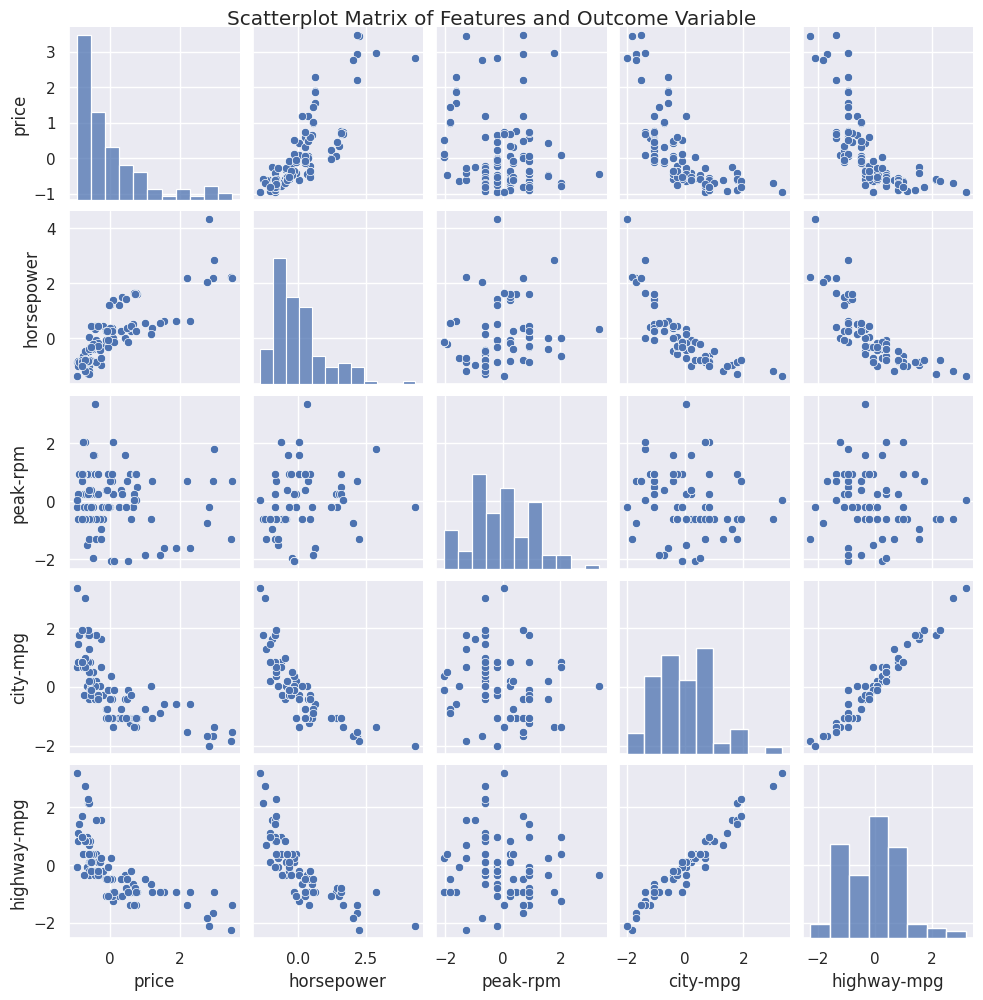

In [ ]:
# YOUR CODE HERE

# Creating scatterplot matrix to visualize pair-wise correlations between
# different features and the outcome variable
df_train = pd.concat([Y_train_std, X_train_std], axis = 1)
sp = sns.pairplot(df_train, height = 2)
sp.fig.suptitle("Scatterplot Matrix of Features and Outcome Variable",
                verticalalignment = 'bottom')

In [ ]:
print("peak-rpm, city-mpg, and highway-mpg all seem to be somewhat normally")
print("distributed. However, it is not necessary for the explanatory or target")
print("variables to be normally distributed in order to train a ML model.")

peak-rpm, city-mpg, and highway-mpg all seem to be somewhat normally
distributed. However, it is not necessary for the explanatory or target
variables to be normally distributed in order to train a ML model.


### <span style="color:chocolate">Exercise 8:</span> Correlation matrix (10 points)

In this exercise you will:

1. Plot a correlation matrix in the form of a heatmap to visualize the linear relationships between different features and outcome in the (X_train_std, Y_train_std) data. Hint: this example here is very useful: https://seaborn.pydata.org/examples/many_pairwise_correlations.html
    
2. Answer the following questions:
 - Which two features are likely to be most redundant?
 - Which feature is likely to be least useful for predicting price?

Text(0.5, 1.0, 'Heatmap of Features and Outcome Variable')

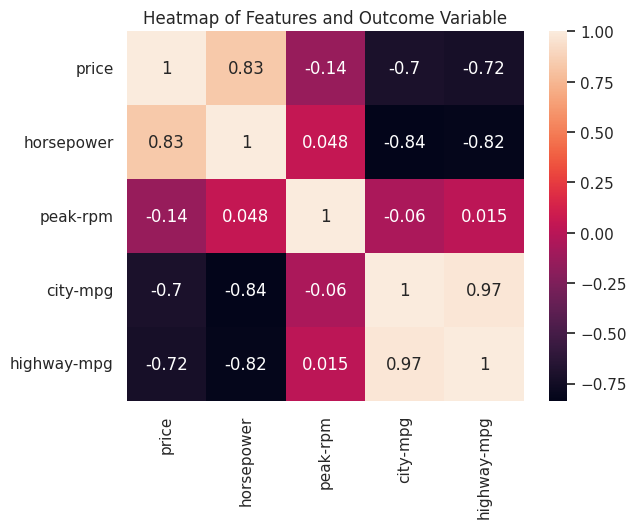

In [ ]:
# YOUR CODE HERE

# Plotting a correlation matrix in heatmap format
cm = df_train.corr()  # Getting the correlation matrix
hm = sns.heatmap(cm, annot = True)
hm.set_title("Heatmap of Features and Outcome Variable")

In [ ]:
print("1. The two features that are most likely to be redundant are city-mpg")
print("and highway-mpg, as they seem to be extremely closely correlated with")
print("one another (correlation of 0.97). This makes sense, as these variables")
print("are both measuring mpg, with the only difference being whether they're")
print("measured in the city or on the highway (which should be comparable).\n")

print("2. peak-rpm has the lowest correlation with price in terms of")
print("magnitude. Therefore, it would seem that peak-rpm is the least useful")
print("feature for predicting price.")

1. The two features that are most likely to be redundant are city-mpg
and highway-mpg, as they seem to be extremely closely correlated with
one another (correlation of 0.97). This makes sense, as these variables
are both measuring mpg, with the only difference being whether they're
measured in the city or on the highway (which should be comparable).

2. peak-rpm has the lowest correlation with price in terms of
magnitude. Therefore, it would seem that peak-rpm is the least useful
feature for predicting price.


---
### Step 4: Modeling

### <span style="color:chocolate">Exercise 9:</span> Baseline model (5 points)

Let's start by evaluating a baseline model. Precisely, you'll use the average price of cars in the training set as our baseline model -- that is, the baseline always predicts the average price regardless of the input.

1. Implement this baseline using the Y_train_std data and print the average price. Note: You can revert the price variable to the original scale for interpretation purposes.

In [ ]:
# YOUR CODE HERE

baseline_yhat = ((Y_train_std * Y_train_stddev) + Y_train_mean).mean().iloc[0]
print("The baseline prediction will stay the same no matter what the input is.")
print("In this case, reverting to the original price variable, the baseline")
print("will always predict the price to be:", round(baseline_yhat, 2))

# Creating Y_hat_baseline_predictions array with mean as prediction for all
Y_hat_baseline_predictions = np.ones(Y_train_std.shape[0]) * baseline_yhat

The baseline prediction will stay the same no matter what the input is.
In this case, reverting to the original price variable, the baseline
will always predict the price to be: 12889.01


### <span style="color:chocolate">Exercise 10:</span> Improvement over Baseline with TensorFlow (10 points)

Let's train a linear regression model much like we did in the previous assignment, but this time using TensorFlow.

1. Fill in the <span style="color:green">NotImplemented</span> parts of the build_model() function below by following the instructions provided as comments. Hint: refer to Demo 3 in [bCourses/Modules/Live Session Demos](https://bcourses.berkeley.edu/courses/1534588/files/88733489?module_item_id=17073646) for an example.
2. Build and compile a model using the build_model() function and the (X_train_std, Y_train_std) data. Set learning_rate = 0.0001. Call the resulting object *model_tf*.
3. Train *model_tf* using the (X_train_std, Y_train_std) data. Set num_epochs = 5. Pass the (X_val_std, Y_val_std) data for validation. Hint: see the documentation behind the [tf.keras.Model.fit()](https://bcourses.berkeley.edu/courses/1534588/files/88733489?module_item_id=17073646) method.
3. Generate a plot with the loss values on the y-axis and the epoch number on the x-axis for visualization. Make sure to include axes name and title. Hint: check what the [tf.keras.Model.fit()](https://bcourses.berkeley.edu/courses/1534588/files/88733489?module_item_id=17073646) method returns.

More notes on point 1: the idea is to build a *computational graph* for linear regression, and then send data through it. There are many ways to build graphs, but [TenforFlow Keras API](https://www.tensorflow.org/api_docs/python/tf/keras) is recommended.

In [ ]:
def build_model(num_features, learning_rate):
  """Build a TF linear regression model using Keras.

  Args:
    num_features: The number of input features.
    learning_rate: The desired learning rate for SGD.

  Returns:
    model: A tf.keras model (graph).
  """
  # This is not strictly necessary, but each time you build a model, TF adds
  # new nodes (rather than overwriting), so the colab session can end up
  # storing lots of copies of the graph when you only care about the most
  # recent. Also, as there is some randomness built into training with SGD,
  # setting a random seed ensures that results are the same on each identical
  # training run.
  tf.keras.backend.clear_session()
  tf.random.set_seed(0)

  # Build a model using keras.Sequential. While this is intended for neural
  # networks (which may have multiple layers), we want just a single layer for
  # linear regression.
  model = tf.keras.Sequential()
  model.add(tf.keras.layers.Dense(
      units=1,                     # output dim
      input_shape=[num_features],  # input dim
      use_bias=True,               # use a bias (intercept) param
      kernel_initializer=tf.ones_initializer,  # initialize params to 1
      bias_initializer=tf.ones_initializer,    # initialize bias to 1
  ))

  # We need to choose an optimizer. We'll use GD, which is actually mini-batch GD
  optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate)

  # Finally, compile the model. This finalizes the graph for training.
  # We specify the MSE loss and the optimizer above
  model.compile(optimizer=optimizer, loss='mse')

  return model

In [ ]:
tf.random.set_seed(0)
# 2. Build and compile model
# YOUR CODE HERE

# Building and compiling the model
model_tf = build_model(num_features = X_train.shape[1], learning_rate = 0.0001)

# 3. Fit the model
# YOUR CODE HERE

# Training model_tf using X_train_std and Y_train_std
model_tf_fit = model_tf.fit(
  x = X_train_std,
  y = Y_train_std,
  validation_data=[X_val_std, Y_val_std],
  epochs=5,
  verbose=1)

Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 88ms/step - loss: 5.5000 - val_loss: 4.8144
Epoch 2/5
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 5.4840 - val_loss: 4.8031
Epoch 3/5
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 5.4681 - val_loss: 4.7919
Epoch 4/5
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 5.4523 - val_loss: 4.7808
Epoch 5/5
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 5.4365 - val_loss: 4.7696


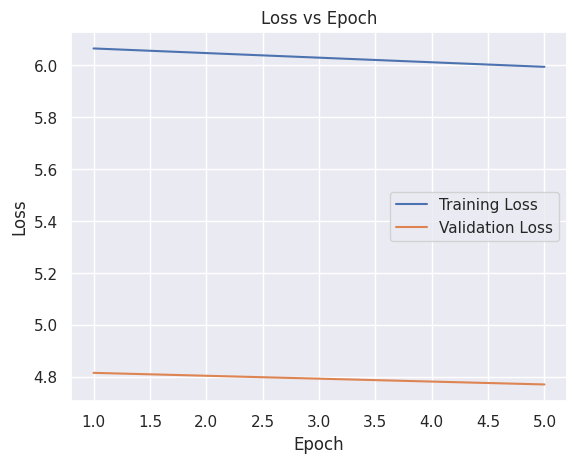

In [ ]:
# Generating a plot with loss on y-axis and epoch on x-axis
hist = model_tf_fit.history
plt.plot(range(1, 6), hist['loss'], label='Training Loss')
plt.plot(range(1, 6), hist['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss vs Epoch')
plt.legend()
plt.show()

---
### Step 5: Hyperparameter tuning

Hyperparameter tuning is a crucial step in optimizing ML models. It involves systematically adjusting hyperparameters such as learning rate, number of epochs, and optimizer to find the model configuration that leads to the best generalization performance.

This tuning process is typically conducted by monitoring the model's performance on the validation vs. training set. It's important to note that using the test set for hyperparameter tuning can compromise the integrity of the evaluation process by violating the assumption of "blindness" of the test data.

### <span style="color:chocolate">Exercise 11:</span> Hyperparameter tuning (10 points)

1. Fine-tune the **learning rate** and **number of epochs** hyperparameters of *model_tf* to determine the setup that yields the most optimal generalization performance. Feel free to explore various values for these hyperparameters. Hint: you can manually test different hyperparameter values or you can use the [Keras Tuner](https://www.tensorflow.org/tutorials/keras/keras_tuner). If you decide to work with the Keras Tuner, define a new model building function named <span style="color:chocolate">build_model_tuner()</span>.

After identifying your preferred model configuration, print the following information:

2. The learned parameters of the tuned model (this should include the bias term). Hint: use  <span style="color:chocolate">[model_name].layers[0].get_weights()</span>.
3. The loss at the final epoch on both the training and validation datasets;
4. The difference between the last-epoch loss observed on the training and validation datasets.


Please note that we will consider 'optimal model configuration' any last-epoch training loss that is below 0.31 and any last epoch validation loss that is below 0.48.

In [ ]:
tf.random.set_seed(0)
# YOUR CODE HERE

# Building and compiling the model using parameters after manual adjustments
model_tf = build_model(num_features = X_train.shape[1], learning_rate = 0.1)

# Training model_tf using X_train_std and Y_train_std
model_tf_fit = model_tf.fit(
  x = X_train_std,
  y = Y_train_std,
  validation_data=[X_val_std, Y_val_std],
  epochs=6,
  batch_size=32,
  verbose=1)

Epoch 1/6


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - loss: 3.5970 - val_loss: 1.2237
Epoch 2/6
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.6396 - val_loss: 0.6750
Epoch 3/6
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.3739 - val_loss: 0.5417
Epoch 4/6
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 0.3169 - val_loss: 0.4899
Epoch 5/6
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.2962 - val_loss: 0.4598
Epoch 6/6
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.2845 - val_loss: 0.4391


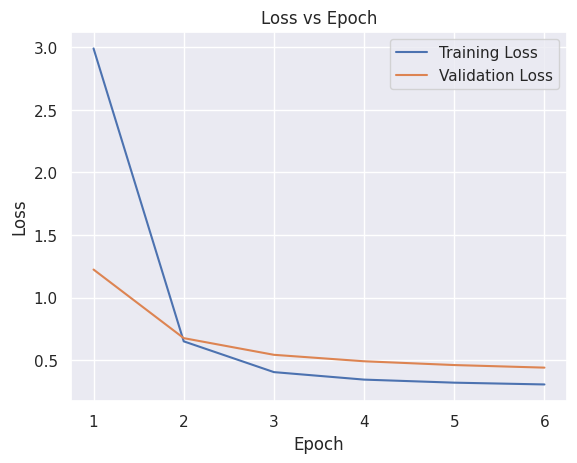

In [ ]:
# Generating a plot with loss on y-axis and epoch on x-axis
hist = model_tf_fit.history
plt.plot(range(1, 7), hist['loss'], label='Training Loss')
plt.plot(range(1, 7), hist['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss vs Epoch')
plt.legend()
plt.show()

In [ ]:
# 1. Identifying optimal model configuration
print("1. A model with a learning rate of 0.1 and epochs of 6 seems to")
print("yield smooth and reasonable training and validation loss curves. These")
print("hyperparameters seem to give us a good sense of how the model is being")
print("trained, and it does not appear that it is overfitting. Lastly, the")
print("last-epoch training loss is below 0.31 and the last-epoch validation")
print("loss is below 0.48.\n")

# 2. Getting the learned parameters of the tuned model (with the bias term)
print("2. The learned parameters for the features of the tuned model are:")
print(model_tf.layers[0].get_weights()[0])
print("where the parameters are horsepower, peak-rpm, city-mpg, & highway-mpg,")
print("respectively.\n")
print("The learned parameter for the bias term of the tuned model is:")
print(model_tf.layers[0].get_weights()[1], '\n')

# 3. The loss at the final epoch on the training and validation datasets
print("3. Loss at the final epoch on the training set:", hist['loss'][-1])
print("Loss at the final epoch on the validation set:", hist['val_loss'][-1])

# 4. The difference between the last-epoch loss observed on the datasets
print("\n4. The difference between the last-epoch loss observed on the")
print("training and validation datasets is:",
      hist['loss'][-1] - hist['val_loss'][-1])


1. A model with a learning rate of 0.1 and epochs of 6 seems to
yield smooth and reasonable training and validation loss curves. These
hyperparameters seem to give us a good sense of how the model is being
trained, and it does not appear that it is overfitting. Lastly, the
last-epoch training loss is below 0.31 and the last-epoch validation
loss is below 0.48.

2. The learned parameters for the features of the tuned model are:
[[ 1.0085415e+00]
 [-2.0104854e-01]
 [ 1.9908512e-01]
 [ 6.1692670e-05]]
where the parameters are horsepower, peak-rpm, city-mpg, & highway-mpg,
respectively.

The learned parameter for the bias term of the tuned model is:
[0.00705744] 

3. Loss at the final epoch on the training set: 0.3045870065689087
Loss at the final epoch on the validation set: 0.43911105394363403

4. The difference between the last-epoch loss observed on the
training and validation datasets is: -0.13452404737472534


---
### Step 6: Evaluation and Generalization


Now that you've determined the optimal set of hyperparameters, it's time to evaluate your optimized (tuned) model on the test data to gauge its performance in real-world scenarios, commonly known as inference.

### <span style="color:chocolate">Exercise 12:</span> Computing MSE (10 points)

1. Calculate the MSE on both (X_train_std, Y_train_std) and (X_test_std, Y_test_std) datasets. Hint: You can utilize the <span style="color:chocolate">model.evaluate()</span> method provided by tf.keras.

2. Does the model demonstrate strong generalization capabilities? Provide an explanation based on your observations.

4. Generate a plot to visualize the accuracy of the predictions. Plot the actual (observed) Y_test values on the x-axis and the predicted Y_test values on the y-axis. Additionally, include a 45-degree line in the plot for reference. Ensure that the plot contains appropriate axis labels and a title. Provide commentary on the model's fit based on this visualization. Hint: You can utilize the <span style="color:chocolate">model.predict()</span> method available in tf.keras.

1. MSE between Y_train_std and the predicted values from X_train_std: 0.2904266119003296
MSE between Y_test_std and the predicted values from X_test_std: 0.2833482325077057 

2. This model does seem to demonstrate strong generalization
capabilities. The training data loss is under 0.30, and even with a
completely unseen test data set, the loss remains about the same, still
under 0.30.

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


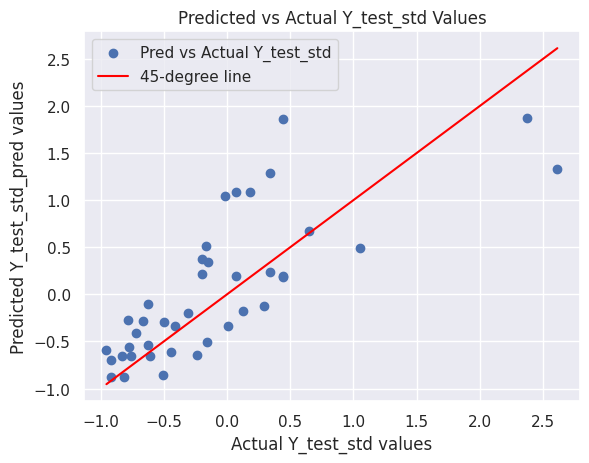

3. Based on this visualization, the model does not seem to do a great
job with its fit. While the model may be generalizable, the error is
still pretty high, and we can see that when comparing the
Y_test_std_pred (predicted) values versus Y_test_std (actual) values
against the red line at 45 degrees. Even though the fit seems better
for values that are below the average of the dataset, the datapoints
are not very tightly clustered around the red line. In fact, there
seem to be many outliers in the data, some of which are over 2 standard
deviations greater than the mean. Therefore, while this model may be
generalizable, its fit is not great, and we can likely minimize the
error by improving or changing the model.


In [ ]:
# YOUR CODE HERE

# 1. Calculating the MSE on X_train_std and Y_train_std
print("1. MSE between Y_train_std and the predicted values from X_train_std:",
      model_tf.evaluate(X_train_std, Y_train_std, verbose = 0))
print("MSE between Y_test_std and the predicted values from X_test_std:",
      model_tf.evaluate(X_test_std, Y_test_std, verbose = 0), '\n')

# 2. Confirming that the model demonstrates strong generalization capabilities
print("2. This model does seem to demonstrate strong generalization")
print("capabilities. The training data loss is under 0.30, and even with a")
print("completely unseen test data set, the loss remains about the same, still")
print("under 0.30.\n")

# 3. Generating a plot to visualize accuracy of the predictions
Y_test_std_pred = model_tf.predict(X_test_std) # Getting Y_test_std predictions

plt.scatter(Y_test_std, Y_test_std_pred, label = 'Pred vs Actual Y_test_std')
plt.plot([Y_test_std.min(), Y_test_std.max()], [Y_test_std.min(),
  Y_test_std.max()], color='red', label="45-degree line")
plt.xlabel('Actual Y_test_std values')
plt.ylabel('Predicted Y_test_std_pred values')
plt.title('Predicted vs Actual Y_test_std Values')
plt.legend()
plt.show()

print("3. Based on this visualization, the model does not seem to do a great")
print("job with its fit. While the model may be generalizable, the error is")
print("still pretty high, and we can see that when comparing the")
print("Y_test_std_pred (predicted) values versus Y_test_std (actual) values")
print("against the red line at 45 degrees. Even though the fit seems better")
print("for values that are below the average of the dataset, the datapoints")
print("are not very tightly clustered around the red line. In fact, there")
print("seem to be many outliers in the data, some of which are over 2 standard")
print("deviations greater than the mean. Therefore, while this model may be")
print("generalizable, its fit is not great, and we can likely minimize the")
print("error by improving or changing the model.")


----
#### <span style="color:chocolate">Additional practice question</span> (not graded)

In Exercise 12, you reported an aggregated MSE. Let's revisit the exercise by:

1. Performing a subgroup evaluation of the model. Specifically, calculate the test data MSE for the following makes: ['alfa-romero', 'audi', 'chevrolet', 'dodge', 'honda'].
2. Addressing the question: Is the model "fair" across each make?

In [ ]:
# YOUR CODE HERE

# Calculating the test data MSE by make

# Retaining only the specified columns
car_data_make = car_data_init[
    ['horsepower', 'peak-rpm', 'city-mpg', 'highway-mpg', 'price']]

# Converting the data type of each column to numeric and coercing missing
# values to NaN
car_data_make = car_data_make.apply(pd.to_numeric, errors = 'coerce')

# Getting the make into the dataframe
car_data_make = pd.concat((car_data_make, car_data_init[['make']]), axis = 1)

# Removing rows that have missing values
car_data_make = car_data_make.dropna(ignore_index = True)

# Getting the indices that match with the test data
car_data_make = car_data_make.loc[Y_test_std.index.values]

# Getting only the specific data for each make
car_data_alfa_romero = car_data_make[car_data_make['make'] == 'alfa-romero']
car_data_audi = car_data_make[car_data_make['make'] == 'audi']
car_data_chevrolet = car_data_make[car_data_make['make'] == 'chevrolet']
car_data_dodge = car_data_make[car_data_make['make'] == 'dodge']
car_data_honda = car_data_make[car_data_make['make'] == 'honda']

# Getting the features and outcome data splits
X_alfa_romero = car_data_alfa_romero[['horsepower', 'peak-rpm', 'city-mpg',
  'highway-mpg']]
Y_alfa_romero = car_data_alfa_romero[['price']]

X_audi = car_data_audi[['horsepower', 'peak-rpm', 'city-mpg',
  'highway-mpg']]
Y_audi = car_data_audi[['price']]

X_chevrolet = car_data_chevrolet[['horsepower', 'peak-rpm', 'city-mpg',
  'highway-mpg']]
Y_chevrolet = car_data_chevrolet[['price']]

X_dodge = car_data_dodge[['horsepower', 'peak-rpm', 'city-mpg',
  'highway-mpg']]
Y_dodge = car_data_dodge[['price']]

X_honda = car_data_honda[['horsepower', 'peak-rpm', 'city-mpg',
  'highway-mpg']]
Y_honda = car_data_honda[['price']]

# Standardizing all features for the makes
X_alfa_romero_std = (X_alfa_romero - X_train_mean) / X_train_stddev
X_audi_std = (X_audi - X_train_mean) / X_train_stddev
X_chevrolet_std = (X_chevrolet - X_train_mean) / X_train_stddev
X_dodge_std = (X_dodge - X_train_mean) / X_train_stddev
X_honda_std = (X_honda - X_train_mean) / X_train_stddev

# Standardizing the outcomes for the makes
Y_alfa_romero_std = (Y_alfa_romero - Y_train_mean) / Y_train_stddev
Y_audi_std = (Y_audi - Y_train_mean) / Y_train_stddev
Y_chevrolet_std = (Y_chevrolet - Y_train_mean) / Y_train_stddev
Y_dodge_std = (Y_dodge - Y_train_mean) / Y_train_stddev
Y_honda_std = (Y_honda - Y_train_mean) / Y_train_stddev

# Calculating the MSE for each make of the test dataset
print("1. Calculating the MSE for each make of the test dataset:")
print("MSE of the test dataset for alfa-romero:",
      model_tf.evaluate(X_alfa_romero_std, Y_alfa_romero_std, verbose = 0))
print("MSE of the test dataset for audi:",
      model_tf.evaluate(X_audi_std, Y_audi_std, verbose = 0))
print("MSE of the test dataset for chevrolet:",
      model_tf.evaluate(X_chevrolet_std, Y_chevrolet_std, verbose = 0))
print("MSE of the test dataset for dodge:",
      model_tf.evaluate(X_dodge_std, Y_dodge_std, verbose = 0))
print("MSE of the test dataset for honda:",
      model_tf.evaluate(X_honda_std, Y_honda_std, verbose = 0))


1. Calculating the MSE for each make of the test dataset:
MSE of the test dataset for alfa-romero: 0.0385516919195652
MSE of the test dataset for audi: 0.13210703432559967
MSE of the test dataset for chevrolet: 0.04523688182234764
MSE of the test dataset for dodge: []
MSE of the test dataset for honda: 0.07925613969564438


/usr/lib/python3.11/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


In [ ]:
print("2. The model is almost definitely not fair across make. Most")
print("importantly, each make is represented at different amounts in the")
print("training, validation, and test datasets, which causes the model to")
print("train more closely to certain makes than others. This also causes some")
print("makes (like dodge) to have no data in the test dataset, which results")
print("in the complete inability to calculate its MSE. Even if we did get")
print("lucky and dodge were in the test dataset, the model would still not be")
print("fair across make as there are simply different numbers of makes in the")
print("dataset. For example, if there were 20 datapoints for one particular")
print("make and only a single datapoint for another make, the model would")
print("clearly not generalize well to that latter make.")

2. The model is almost definitely not fair across make. Most
importantly, each make is represented at different amounts in the
training, validation, and test datasets, which causes the model to
train more closely to certain makes than others. This also causes some
makes (like dodge) to have no data in the test dataset, which results
in the complete inability to calculate its MSE. Even if we did get
lucky and dodge were in the test dataset, the model would still not be
fair across make as there are simply different numbers of makes in the
dataset. For example, if there were 20 datapoints for one particular
make and only a single datapoint for another make, the model would
clearly not generalize well to that latter make.
